In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../..")

In [3]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [4]:
dataset = "mnist"
algo = "modular"
prefilter_strategy = "None"
scorer = "cross_entropy"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = False
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = None  # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)

cfg.sharing_strategy = DictConfig({
    "name": "recv_data",
    "scorer": scorer,
    "num_queries": 5,
    'num_data_neighbors': 5,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": 50,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
    "use_ood_separation_loss": True,
})

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': False}}


INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [5]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)

In [6]:
def setup_fleet(task_id=None): 
    fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)
    if task_id is not None:
        fleet.load_model_from_ckpoint(task_ids=task_id)
    return fleet

def add_random_module(receiver, task_id):
    if len(receiver.net.candidate_indices) == 0:
        receiver.net.add_tmp_modules(task_id, num_modules=1)

def transfer_module(receiver, sender, task_id):
    new_module = sender.net.components[-1]
    add_random_module(receiver, task_id)
    receiver.net.receive_modules(task_id, [new_module])

def transfer_decoder(receiver, sender, rcv_task_id, sender_task_id=None):
    if sender_task_id is None:
        sender_task_id = rcv_task_id
    receiver.net.decoder[rcv_task_id].load_state_dict(sender.net.decoder[sender_task_id].state_dict())

@torch.no_grad()
def transfer_structure(receiver, sender, task_id):
    target = receiver.net.structure[task_id]
    source = sender.net.structure[task_id]
    if target.shape == source.shape:
        target.copy_(source)

In [7]:
def run_counterfactual_scenario(scenario, task_id=None, agent_id=None):
    total_results = defaultdict(dict)
    task_ids = range(cfg.num_init_tasks, num_tasks) if task_id is None else [task_id]
    agent_ids = range(len(setup_fleet().agents)) if agent_id is None else [agent_id]

    for t_id in task_ids:
        print('task', t_id)
        target_fleet = setup_fleet(t_id-1)
        source_fleet = setup_fleet(t_id)
        for a_id in agent_ids:
            print('a_id', a_id)
            target_agent = target_fleet.agents[a_id]
            source_agent = source_fleet.agents[a_id] 

            results = {'Raw': None, 'Transfer Decoder': None, 'Decoder + Structure': None}

            if scenario == "no new module":
                pass
            elif scenario == "optimized module":
                transfer_module(target_agent, source_agent, t_id)
            elif scenario == "random module":
                add_random_module(target_agent, t_id)

            results['Raw'] = target_agent.eval_test(t_id)
            
            transfer_decoder(target_agent, source_agent, t_id)
            results['Transfer Decoder'] = target_agent.eval_test(t_id)

            transfer_structure(target_agent, source_agent, t_id)
            results['Decoder + Structure'] = target_agent.eval_test(t_id)

            total_results[t_id][a_id] = results

    return total_results


In [8]:
def run_opt_module_struct(scenario, target_agent, source_agent, task_id, train_candidate_module=True):
    if "optimized_module" in scenario:
        transfer_module(target_agent, source_agent, task_id)
        train_candidate_module = False if "frozen" in scenario else True
    elif scenario == "random_module":
        add_random_module(target_agent, task_id)
        train_candidate_module = True
    else:
        raise NotImplementedError

    target_agent.agent.T = task_id
    target_agent.update_replay_buffer(task_id-1)
    target_agent.agent.change_save_dir(target_agent.agent.save_dir.replace(experiment_name, experiment_name + "_modmod_eng_" + scenario))
    # opt the last component
    # target_agent.net.active_candidate_index = target_agent.net.num_components-1
    # target_agent.net.candidate_indices = [target_agent.net.num_components-1]
    # print(target_agent.net.candidate_indices, target_agent.net.active_candidate_index)

    target_agent.train(task_id, train_candidate_module=train_candidate_module,
                       save_freq=10,
                       num_candidate_modules=0,)
    return target_agent

In [9]:
def run_training_scenario(scenario, task_id, agent_id):
    target_fleet = setup_fleet(task_id-1)
    target_agent = target_fleet.agents[agent_id]

    source_fleet = setup_fleet(task_id)
    source_agent = source_fleet.agents[agent_id] 
    return run_opt_module_struct(scenario, target_agent, source_agent, task_id)

In [10]:
def run_learning_speed_scenario(scenario, source_agent_id, target_agent_id,
                                source_task, target_task):
    fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                        LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                        train_kwargs=train_cfg, **fleet_additional_cfg)
    source_agent = fleet.agents[source_agent_id]
    target_agent = fleet.agents[target_agent_id]

    source_agent.load_model_from_ckpoint(task_id=source_task)
    target_agent.load_model_from_ckpoint(task_id=target_task-1)
    return run_opt_module_struct(scenario, target_agent, source_agent, target_task)

## Counterfactual
Same exact model

### Zero-shot Transfer

In [ ]:

def plot_performance(res):
    categories = ['Raw', 'Transfer Decoder', 'Decoder + Structure']
    task_ids = sorted(res.keys())
    means = {category: [] for category in categories}
    stds = {category: [] for category in categories}

    for t_id in task_ids:
        for category in categories:
            scores = [res[t_id][a_id][category][t_id] for a_id in res[t_id]]
            means[category].append(np.mean(scores))
            stds[category].append(np.std(scores))

    plt.figure(figsize=(10, 6))
    for category in categories:
        mean_scores = means[category]
        std_scores = stds[category]
        plt.plot(task_ids, mean_scores, label=category)
        plt.fill_between(task_ids, np.subtract(mean_scores, std_scores), np.add(mean_scores, std_scores), alpha=0.2)

    plt.xlabel('Task ID')
    plt.ylabel('Average Performance')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
res = run_counterfactual_scenario("no new module")

In [ ]:
plot_performance(res)

In [ ]:
res = run_counterfactual_scenario("optimized module")
plot_performance(res)

In [ ]:
res = run_counterfactual_scenario("random module")
plot_performance(res)

### Learning speed
Only transfer the module. Receiver optimized the structure and decoder on its own.

In [11]:
target_agent = run_training_scenario("optimized_module_frozen", task_id=4, agent_id=0)

INFO:root:Agent: node_id: 0, seed: 0


INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238

In [12]:
random_module_target_agent = run_training_scenario("random_module", task_id=4, agent_id=0)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0


INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70677746	acc: 0.498
INFO:root:	task: avg	loss: 0.25990589	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69333265	acc: 0.498
INFO:root:	task: avg	loss: 0.

In [13]:
unfrozen_target_agent = run_training_scenario("optimized_module", task_id=4, agent_id=0)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.77788422	acc: 0.498
INFO:root:	task: avg	loss: 0.27412725	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70631869	acc

In [14]:
df = target_agent.agent.record.df
unfrozen_df = unfrozen_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

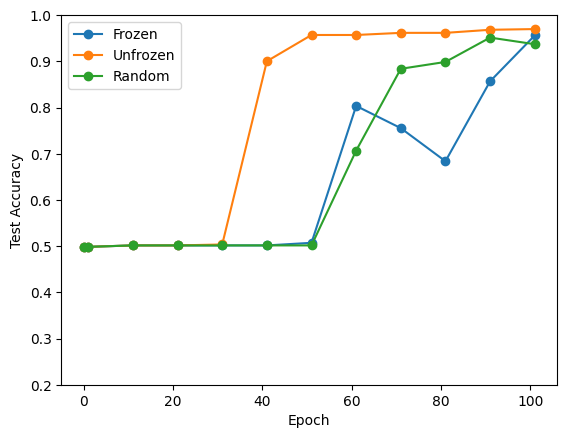

In [15]:
# plot test_task with epoch
test_task = 4
fig, ax = plt.subplots()
df[df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

## Task Similarity between neighbors

In [16]:
fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000


INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [17]:
for agent in fleet.agents:
    print(agent.dataset.class_sequence[2*4:])

[8 0 1 0 5 9 6 4 9 0 3 0]
[5 0 3 6 2 7 6 7 6 1 0 5]
[6 1 6 4 5 7 8 0 2 3 0 3]
[4 5 9 3 0 6 9 1 3 1 7 9]
[2 1 7 6 8 6 1 8 6 4 9 8]
[4 9 3 2 2 9 6 0 5 9 7 2]
[4 6 1 3 3 1 4 1 9 2 6 2]
[5 0 7 2 7 8 6 1 6 0 0 6]


In [18]:
source_agent_id, target_agent_id = 2, 0
source_task, target_task = 7, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]

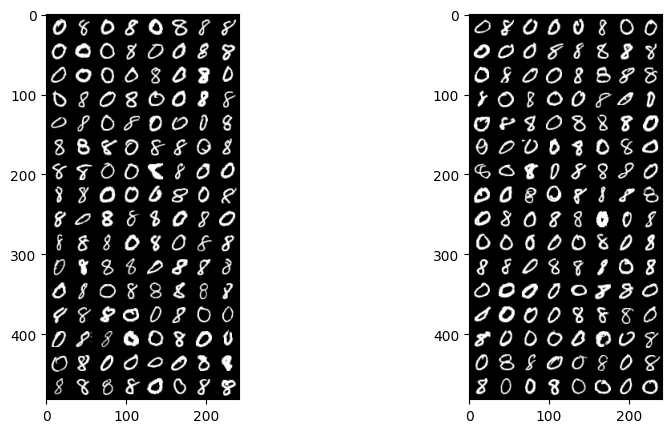

In [19]:
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

In [20]:

add_modules_record = os.path.join(
    source_agent.save_dir, "add_modules_record.csv")
df = pd.read_csv(add_modules_record)
df

,task_id,best_candidate_idx,best_improvement,num_components,add_new_module
0,4,4,0.371429,5,True
1,5,5,0.350000,6,True
2,6,6,0.134146,7,True
3,7,7,0.148148,8,True
4,8,8,0.440000,9,True
5,9,9,0.032967,9,False


In [21]:

add_modules_record = os.path.join(
    target_agent.save_dir, "add_modules_record.csv")
df = pd.read_csv(add_modules_record)
df

,task_id,best_candidate_idx,best_improvement,num_components,add_new_module
0,4,4,-0.010101,4,False
1,5,4,0.000000,4,False
2,6,4,0.153846,5,True
3,7,5,0.032258,5,False
4,8,5,0.020833,5,False
5,9,5,0.066667,6,True


In [22]:
source_agent.load_model_from_ckpoint(task_id=source_task)
target_agent.load_model_from_ckpoint(task_id=target_task-1)

In [23]:
target_agent.eval_test(target_task)

{0: 0.9551282051282052,
 1: 0.9613453815261044,
 2: 0.9634020618556701,
 3: 0.9678714859437751,
 4: 0.4984646878198567,
 'avg': 0.8692423644547222}

In [24]:
# transfer_decoder(target_agent, source_agent, target_task, source_task)
# target_agent.eval_test(target_task)
'''
{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}
 '''

"\n{0: 0.9615384615384616,\n 1: 0.9839357429718876,\n 2: 0.9695876288659794,\n 3: 0.9809236947791165,\n 4: 0.4984646878198567,\n 'avg': 0.8788900431950604}\n "

In [25]:
# transfer_module(target_agent, source_agent, target_task)
# target_agent.eval_test(target_task)
'''
{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}
 '''

"\n{0: 0.9615384615384616,\n 1: 0.9839357429718876,\n 2: 0.9695876288659794,\n 3: 0.9809236947791165,\n 4: 0.4984646878198567,\n 'avg': 0.8788900431950604}\n "

In [26]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70260196	acc: 0.498
INFO:root:	task: avg	loss: 0.25907079	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69175653	acc: 0.498
INFO:root:	task: avg	loss: 0.25690171	acc: 0.869
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69827577	acc: 0.502
INFO:root:	task: avg	loss: 0.25820555	acc: 0.870
INFO:root:epochs: 21, training ta

In [27]:
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.78860785	acc: 0.498
INFO:root:	task: avg	loss: 0.27627197	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.71941743	acc: 0.498
INFO:root:	task: avg	loss: 0.26243389	acc: 0.869
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70283882	acc: 0.502
INFO:root:	task: avg	loss: 0.25911816	acc: 0.870
INFO:root:epochs: 21, training ta

In [28]:
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.78860785	acc: 0.498
INFO:root:	task: avg	loss: 0.27627197	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.72285150	acc: 0.498
INFO:root:	task: avg	loss: 0.26312070	acc: 0.869
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70182874	acc: 0.502
INFO:root:	task: avg	loss: 0.25891615	acc: 0.870
INFO:root:epochs: 21, training ta

In [29]:
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

In [30]:
frozen_mod_target_agent.agent.record.df

,train_task,test_task,test_acc,test_loss,epoch
0,4,0,0.955128,0.171273,0
0,4,1,0.961345,0.137677,0
0,4,2,0.963402,0.161412,0
0,4,3,0.967871,0.122390,0
0,4,4,0.498465,0.788608,0
...,...,...,...,...,...
0,4,1,0.961345,0.138504,101
0,4,2,0.963402,0.164149,101
0,4,3,0.967871,0.122169,101
0,4,4,0.509212,0.623370,101


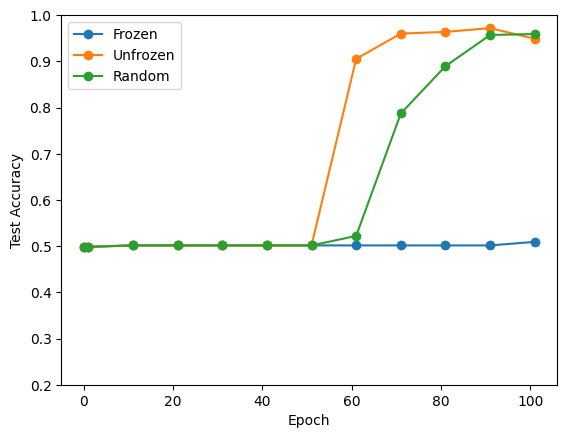

In [31]:
# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Two tasks have something in common but not completely identical

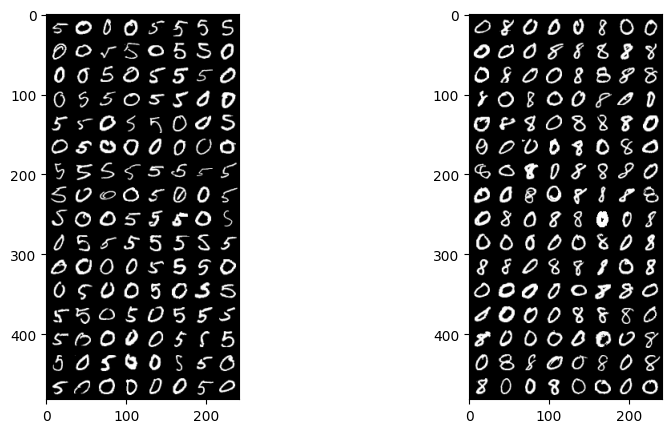

In [32]:
source_agent_id, target_agent_id = 1, 0
source_task, target_task = 4, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70518017	acc: 0.498
INFO:root:	task: avg	loss: 0.25958644	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69252265	acc: 0.498
INFO:root:	task: avg	loss: 0.25705493	acc: 0.869
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69341925	acc: 0.502
INFO:root:	task: avg	loss: 0.25723425	acc: 0.870
INFO:root:epochs: 21, training ta

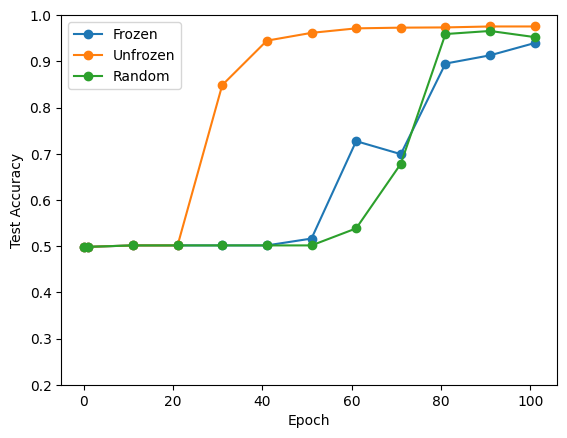

In [33]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Source and target tasks have nothing in common

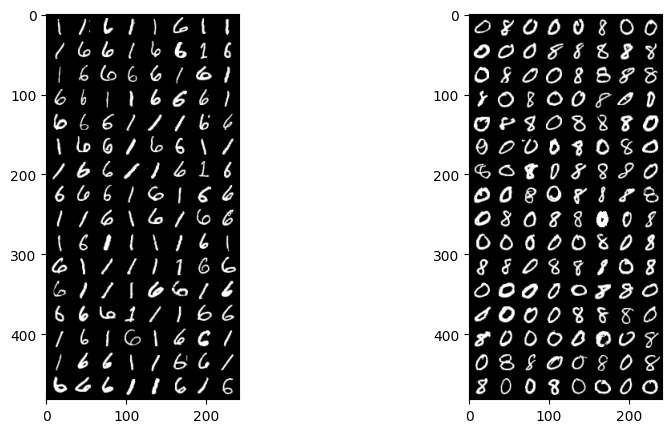

In [34]:
source_agent_id, target_agent_id = 2, 0
source_task, target_task = 4, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.70518017	acc: 0.498
INFO:root:	task: avg	loss: 0.25958644	acc: 0.869
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69252265	acc: 0.498
INFO:root:	task: avg	loss: 0.25705493	acc: 0.869
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.17127308	acc: 0.955
INFO:root:	task: 1	loss: 0.13767708	acc: 0.961
INFO:root:	task: 2	loss: 0.16141203	acc: 0.963
INFO:root:	task: 3	loss: 0.12238981	acc: 0.968
INFO:root:	task: 4	loss: 0.69341925	acc: 0.502
INFO:root:	task: avg	loss: 0.25723425	acc: 0.870
INFO:root:epochs: 21, training ta

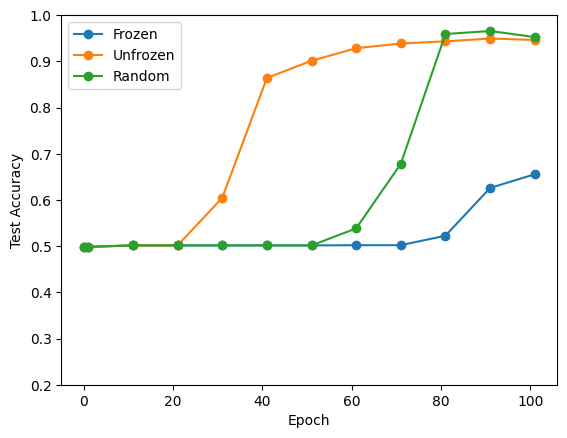

In [35]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);